# **Installing Libraries**

In [ ]:
import os
import seaborn as sns
import itertools
import collections
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import networkx as nx
import tweepy as tw
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# **Accessing Twitter API**

In [ ]:
# Twitter API Credentials
consumerKey = ""
consumerSecret = ""
accessToken = ""
accessTokenSecret = ""

In [ ]:
# Create the authentication object
authenticate = tw.OAuthHandler(consumerKey, consumerSecret)

# Set the access token and the access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

# Create the API object while passing in the Auth information
api = tw.API(authenticate, wait_on_rate_limit=True)

# **Get Tweets**

In [ ]:
topic = "#uscapitol"
query = tw.Cursor(api.search, q = topic, lang="en", since='2021-01-08', until='2021-01-09').items(1000)
tweets = [{'Tweets':tweet.text, 'Timestamp': tweet.created_at} for tweet in query]
print(tweets)

[{'Tweets': "RT @SatlokChannel: Trump's supporters stormed the #USCapitol Washington DC on Wednesday. Sat-Bhakti of Supreme God Kabir Sahib Ji is the Tr…", 'Timestamp': datetime.datetime(2021, 1, 8, 23, 59, 19)}, {'Tweets': 'RT @DrLearnALot: Clarence Thomas was escorted onto the Supreme Court by none other than Joseph Biden. I will never forget watching in horro…', 'Timestamp': datetime.datetime(2021, 1, 8, 23, 58, 38)}, {'Tweets': "Just realised any McDonald's in the UK   past 9pm with all the McDonald's security is more secure than the capitol #USCapitol", 'Timestamp': datetime.datetime(2021, 1, 8, 23, 58, 37)}, {'Tweets': "RT @PurveyorOfSass: Unsure of who the artist is, but they've captured it perfectly. #25thAmendmentNow #USCapitol #treason #SAVEUSA #TrumpMe…", 'Timestamp': datetime.datetime(2021, 1, 8, 23, 58, 7)}, {'Tweets': 'RT @Foxtrot_Cop: Officers from a number of law enforcement agencies drive to the hospital to show their support for #USCapitol police offic…', 'Timestamp':

In [ ]:
# Remove Duplicate Tweets
res = [] 
[res.append(x) for x in tweets if x not in res] 
print(res)

[{'Tweets': "RT @SatlokChannel: Trump's supporters stormed the #USCapitol Washington DC on Wednesday. Sat-Bhakti of Supreme God Kabir Sahib Ji is the Tr…", 'Timestamp': datetime.datetime(2021, 1, 8, 23, 59, 19)}, {'Tweets': 'RT @DrLearnALot: Clarence Thomas was escorted onto the Supreme Court by none other than Joseph Biden. I will never forget watching in horro…', 'Timestamp': datetime.datetime(2021, 1, 8, 23, 58, 38)}, {'Tweets': "Just realised any McDonald's in the UK   past 9pm with all the McDonald's security is more secure than the capitol #USCapitol", 'Timestamp': datetime.datetime(2021, 1, 8, 23, 58, 37)}, {'Tweets': "RT @PurveyorOfSass: Unsure of who the artist is, but they've captured it perfectly. #25thAmendmentNow #USCapitol #treason #SAVEUSA #TrumpMe…", 'Timestamp': datetime.datetime(2021, 1, 8, 23, 58, 7)}, {'Tweets': 'RT @Foxtrot_Cop: Officers from a number of law enforcement agencies drive to the hospital to show their support for #USCapitol police offic…', 'Timestamp':

In [ ]:
# Change Variable back to Tweets
tweets = res

In [ ]:
# Convert List to DataFrame
tweets = pd.DataFrame(tweets)

# Add Back Original Column Names
tweets = tweets.rename(columns={0:'Tweets'}) 
tweets = tweets.rename(columns={1:'Timestamp'})

tweets

,Tweets,Timestamp
0,RT @SatlokChannel: Trump's supporters stormed ...,2021-01-08 23:59:19
1,RT @DrLearnALot: Clarence Thomas was escorted ...,2021-01-08 23:58:38
2,Just realised any McDonald's in the UK past ...,2021-01-08 23:58:37
3,RT @PurveyorOfSass: Unsure of who the artist i...,2021-01-08 23:58:07
4,RT @Foxtrot_Cop: Officers from a number of law...,2021-01-08 23:58:06
...,...,...
992,All the Karen’s out there keep that same energ...,2021-01-08 20:24:41
993,"So Trump, Rudy, Cruz, Hawley, etc incite the m...",2021-01-08 20:24:35
994,President-elect @JoeBiden calls members of the...,2021-01-08 20:24:35
995,RT @8ighthHokage: Well she ain’t woke nomore #...,2021-01-08 20:24:35


In [ ]:
def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # Removed @ mentions
  text = re.sub(r'#', '', text) # Removing the # symbol
  text = re.sub(r':', '', text) # Removing the : symbol
  text = re.sub(r'!', '', text) # Removing the ! symbol
  text = re.sub(r'RT[\s]+', '', text) # Removing RT (for retweets) from the text

  return text

tweets['Tweets'] = tweets['Tweets'].apply(cleanTxt)
tweets

,Tweets,Timestamp
0,Trump's supporters stormed the USCapitol Washi...,2021-01-08 23:59:19
1,Clarence Thomas was escorted onto the Supreme ...,2021-01-08 23:58:38
2,Just realised any McDonald's in the UK past ...,2021-01-08 23:58:37
3,"Unsure of who the artist is, but they've captu...",2021-01-08 23:58:07
4,_Cop Officers from a number of law enforcement...,2021-01-08 23:58:06
...,...,...
992,All the Karen’s out there keep that same energ...,2021-01-08 20:24:41
993,"So Trump, Rudy, Cruz, Hawley, etc incite the m...",2021-01-08 20:24:35
994,President-elect calls members of the mob that...,2021-01-08 20:24:35
995,Well she ain’t woke nomore uscapitol AshliBabb...,2021-01-08 20:24:35


In [ ]:
def remove_url(txt):
    url_pattern = re.compile(r'https?//\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

In [ ]:
# Remove URLs
tweets_no_urls = tweets['Tweets'].apply(remove_url)

# Create a sublist of lower case words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection words
collection_words = [',', 'USCapitol', 'uscapitol', 'UScapitol', 'usCapitol', 'UsCapitol', 'uScapitol', 'Capitol', 'capitol', '.', 'uscapitol.', 'USCapitol.', 'UScapitol.', 'usCapitol.', 'UsCapitol.', 'uScapitol.', 'capitol.', 'Capitol.']

tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# View bigrams for the first tweet
terms_bigram[0]

[("trump's", 'supporters'),
 ('supporters', 'stormed'),
 ('stormed', 'washington'),
 ('washington', 'dc'),
 ('dc', 'wednesday.'),
 ('wednesday.', 'sat-bhakti'),
 ('sat-bhakti', 'supreme'),
 ('supreme', 'god'),
 ('god', 'kabir'),
 ('kabir', 'sahib'),
 ('sahib', 'ji'),
 ('ji', 'tr…')]

In [ ]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(30)

[(('pm', 'responding'), 94),
 (('responding', 'attack'), 94),
 (('attack', "“we've"), 94),
 (("“we've", 'also'), 94),
 (('also', 'seen'), 94),
 (('seen', 'week'), 94),
 (('week', 'democracy'), 94),
 (('democracy', 'resilient'), 94),
 (('resilient', 'americ…'), 94),
 (('adam', 'boulton'), 35),
 (('clarence', 'thomas'), 33),
 (('thomas', 'escorted'), 33),
 (('escorted', 'onto'), 33),
 (('onto', 'supreme'), 33),
 (('supreme', 'court'), 33),
 (('court', 'none'), 33),
 (('none', 'joseph'), 33),
 (('joseph', 'biden.'), 33),
 (('biden.', 'never'), 33),
 (('never', 'forget'), 33),
 (('forget', 'watching'), 33),
 (('watching', 'horro…'), 33),
 (('regret', 'violence'), 33),
 (('violence', 'don’t'), 33),
 (('don’t', 'regret'), 33),
 (('regret', 'there.'), 33),
 (('there.', 'riot,'), 33),
 (('riot,', 'peaceful'), 33),
 (('peaceful', 'protest'), 33),
 (('protest', 'vincent'), 33)]

In [ ]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(pm, responding)",94
1,"(responding, attack)",94
2,"(attack, “we've)",94
3,"(“we've, also)",94
4,"(also, seen)",94
5,"(seen, week)",94
6,"(week, democracy)",94
7,"(democracy, resilient)",94
8,"(resilient, americ…)",94
9,"(adam, boulton)",35


In [ ]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

In [ ]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

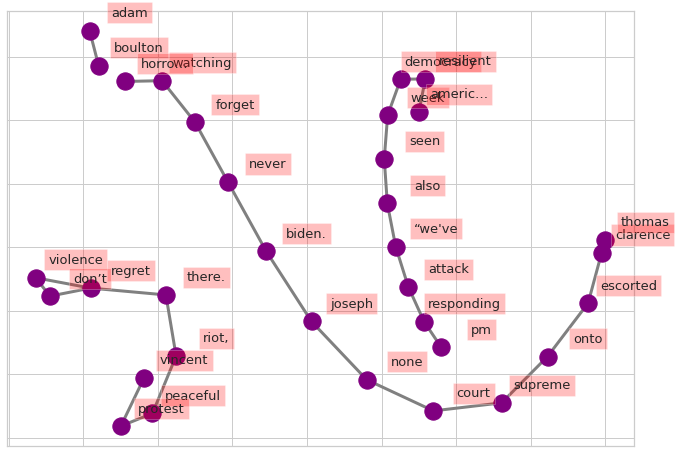

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()